In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import random
import pandas as pd
from glob import glob
import os


In [2]:
# !ls "results_sims/sims"

In [3]:
LR = 0.001
data_path = "results_sims_steps/sims"

In [4]:
class CombinedArrayDataset(Dataset):
    def __init__(self, folder_path):
        # Load all CSV files in the folder
        csv_files = glob(os.path.join(folder_path, "*.csv"))
        data_frames = [pd.read_csv(file) for file in csv_files]
        combined_df = pd.concat(data_frames, ignore_index=True)

        # Parse the arrays and labels
        self.belief = combined_df['belief'].apply(lambda x: np.array(eval(x), dtype=np.float32)).tolist()
        self.ship = combined_df['ship'].apply(lambda x: np.array(eval(x), dtype=np.float32)).tolist()
        self.labels = combined_df['remain'].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Get the array and label for the given index
        belief = self.belief[idx]
        ship = self.ship[idx]
        label = self.labels[idx]

        # Convert to PyTorch tensors
        belief = torch.tensor(belief, dtype=torch.float32)  # Ensure float32 for features
        ship = torch.tensor(ship, dtype= torch.float32)
        label = torch.tensor(label, dtype=torch.float32)  # Ensure long for labels

        # Combine belief and ship as two channels
        input_tensor = torch.stack((belief, ship), dim=0)  # Shape: (2, height, width)
        return input_tensor, label

# Example usage

dataset = CombinedArrayDataset(data_path)


In [5]:
len(dataset)

122290

In [6]:
input, label = dataset[0]
input.shape, label

(torch.Size([2, 30, 30]), tensor(118.))

In [7]:
class SpaceRatNetwork_1fc(nn.Module):
    def __init__(self):
        super(SpaceRatNetwork_1fc, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(2, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3600, 128)
        self.relu1 = nn.ReLU()
        self.fc4 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = self.conv_layer(x)
        # print(x.shape)
        x = self.flatten(x)
        # print(x.shape)
        x = self.relu1(self.fc1(x))
        x = self.fc4(x)
        return x 
        

In [8]:
class SpaceRatNetwork_2fc(nn.Module):
    def __init__(self):
        super(SpaceRatNetwork_2fc, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(2, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3600, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 128)
        self.relu2 = nn.ReLU()
        self.fc4 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = self.conv_layer(x)
        # print(x.shape)
        x = self.flatten(x)
        # print(x.shape)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc4(x)
        return x 
        

In [9]:
class SpaceRatNetwork_3fc(nn.Module):
    def __init__(self):
        super(SpaceRatNetwork_3fc, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(2, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3600, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 128)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = self.conv_layer(x)
        # print(x.shape)
        x = self.flatten(x)
        # print(x.shape)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        return x 
        

In [15]:
# dataset = CustomDataset(data_path)

# Train-Test Split (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [16]:
device = torch.device("mps" if torch.has_mps else "cpu")
print(f"using device: {device}")

using device: mps


/var/folders/j2/56dmz8kj7h5fyr879140wlzr0000gn/T/ipykernel_68745/1369860056.py:1: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps" if torch.has_mps else "cpu")


In [17]:
model_1 = SpaceRatNetwork_1fc().to(device)
loss_function1 = nn.MSELoss()
optimizer1 = torch.optim.Adam(model_1.parameters(), lr=LR)

model_2 = SpaceRatNetwork_2fc().to(device)
loss_function2 = nn.MSELoss()
optimizer2 = torch.optim.Adam(model_2.parameters(), lr=LR)

model_3 = SpaceRatNetwork_1fc().to(device)
loss_function3 = nn.MSELoss()
optimizer3 = torch.optim.Adam(model_3.parameters(), lr=LR)

In [18]:
model_1.train()
train_losses1 = []
test_losses1 = []

model_2.train()
train_losses2 = []
test_losses2 = []

model_3.train()
train_losses3 = []
test_losses3 = []

In [19]:
num_epochs = 50
for epoch in range(num_epochs):
    model_1.train()
    model_2.train()
    model_3.train()
    train_loss1 = 0.0
    train_loss2 = 0.0
    train_loss3= 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        # Zero the gradients
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        optimizer3.zero_grad()
        
        
        # Forward pass
        outputs1 = model_1(inputs)
        outputs2 = model_2(inputs)
        outputs3 = model_3(inputs)
        
        # Compute the loss
        loss1 = loss_function1(outputs1.squeeze(), targets)
        train_loss1 += loss1.item()
        loss2 = loss_function2(outputs2.squeeze(), targets)
        train_loss2 += loss2.item()
        loss3 = loss_function3(outputs3.squeeze(), targets)
        train_loss3 += loss3.item()
        
        # Backward pass and optimization
        loss1.backward()
        optimizer1.step()
        loss2.backward()
        optimizer2.step()
        loss3.backward()
        optimizer3.step()
        
    avg_train_loss1 = train_loss1 / len(train_loader)
    train_losses1.append(avg_train_loss1)
    avg_train_loss2 = train_loss2 / len(train_loader)
    train_losses2.append(avg_train_loss2)
    avg_train_loss3 = train_loss3 / len(train_loader)
    train_losses3.append(avg_train_loss3)
    # print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

    # Testing Loop
    model_1.eval()
    model_2.eval()
    model_3.eval()
    test_loss1 = 0.0
    test_loss2 = 0.0
    test_loss3= 0.0
    with torch.no_grad():  # No need to compute gradients during testing
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            # Forward pass
            outputs1 = model_1(inputs)
            outputs2 = model_2(inputs)
            outputs3 = model_3(inputs)
            
            # Compute the loss
            loss1 = loss_function1(outputs1.squeeze(), targets)
            test_loss1 += loss1.item()
            loss2 = loss_function2(outputs2.squeeze(), targets)
            test_loss2 += loss2.item()
            loss3 = loss_function3(outputs3.squeeze(), targets)
            test_loss3 += loss3.item()

    avg_test_loss1 = test_loss1 / len(test_loader)
    test_losses1.append(avg_test_loss1)
    avg_test_loss2 = test_loss2 / len(test_loader)
    test_losses2.append(avg_test_loss2)
    avg_test_loss3 = test_loss3 / len(test_loader)
    test_losses3.append(avg_test_loss3)
    
    print(f"Epoch {epoch+1}/{num_epochs}| Train1:{avg_train_loss1:.4f}, Test1:{avg_test_loss1:.4f} | Train2:{avg_train_loss2:.4f}, Test2:{avg_test_loss2:.4f} | Train3:{avg_train_loss3:.4f}, Test3:{avg_test_loss3:.4f}|")

Epoch 1/50| Train1:2298.1972, Test1:1734.5381 | Train2:2124.8179, Test2:1702.4659 | Train3:2214.8004, Test3:1738.4629|
Epoch 2/50| Train1:1736.3385, Test1:1685.3169 | Train2:1702.6512, Test2:1663.7438 | Train3:1742.5322, Test3:1699.4568|
Epoch 3/50| Train1:1682.1838, Test1:1644.7639 | Train2:1641.3211, Test2:1587.6798 | Train3:1688.9291, Test3:1652.9017|
Epoch 4/50| Train1:1642.9938, Test1:1588.0042 | Train2:1587.5872, Test2:1522.5938 | Train3:1648.8822, Test3:1596.9248|
Epoch 5/50| Train1:1611.0617, Test1:1554.6365 | Train2:1544.7294, Test2:1471.1993 | Train3:1619.6297, Test3:1564.2142|
Epoch 6/50| Train1:1575.8593, Test1:1525.0623 | Train2:1495.3576, Test2:1454.1698 | Train3:1590.0016, Test3:1545.3947|
Epoch 7/50| Train1:1542.5308, Test1:1499.6980 | Train2:1446.2242, Test2:1395.7749 | Train3:1565.4131, Test3:1534.2201|
Epoch 8/50| Train1:1510.3651, Test1:1462.3078 | Train2:1391.4423, Test2:1323.8492 | Train3:1540.0695, Test3:1489.7799|
Epoch 9/50| Train1:1478.0382, Test1:1464.7116 | 

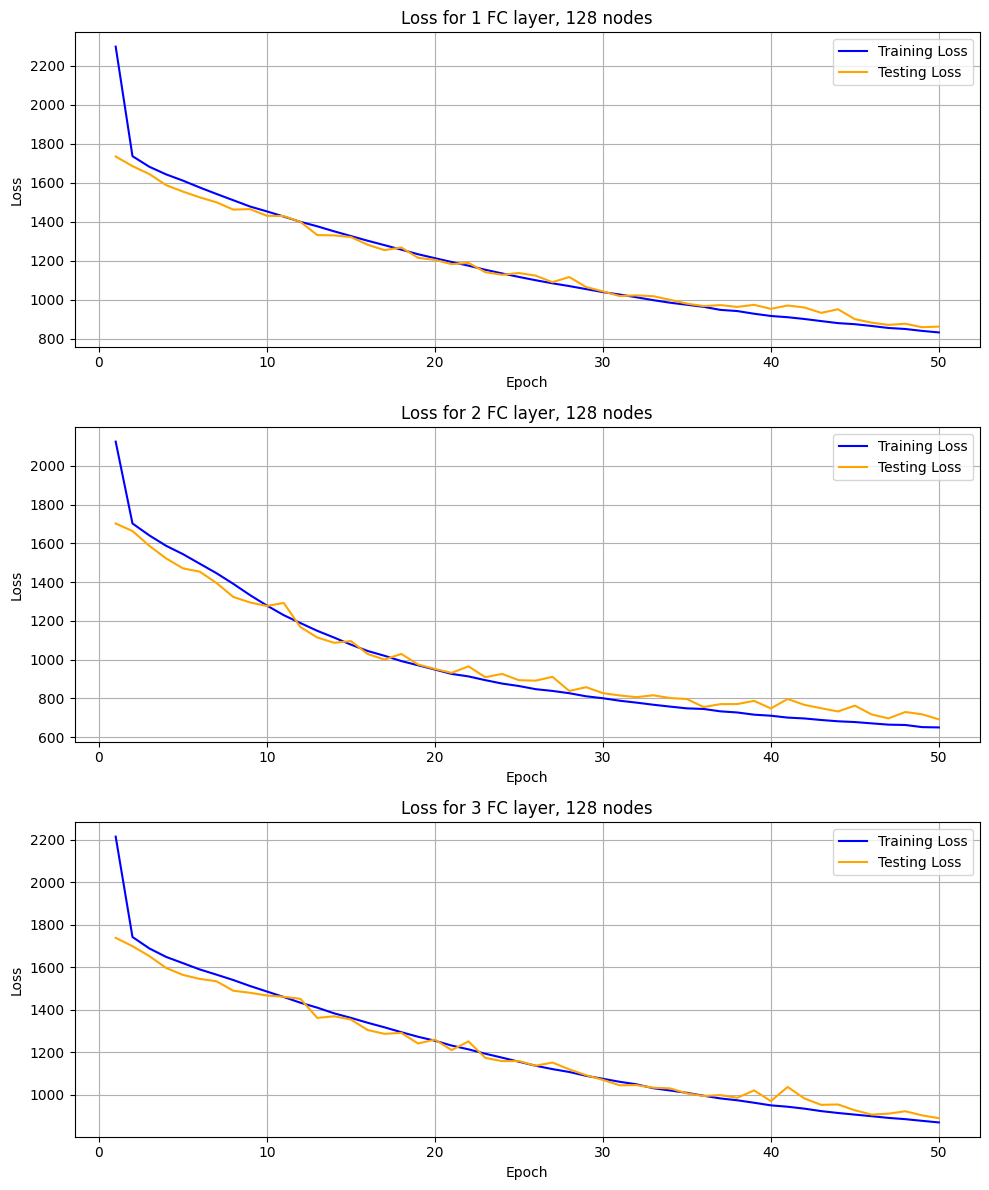

In [20]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12))  # 3 rows, 1 column

# Subplot 1: Training Loss
axes[0].plot(range(1, len(train_losses1) + 1), train_losses1, label='Training Loss', color='blue')
axes[0].plot(range(1, len(test_losses1) + 1), test_losses1, label='Testing Loss', color='orange')
axes[0].set_title('Loss for 1 FC layer, 128 nodes')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Subplot 2: Testing Loss
axes[1].plot(range(1, len(train_losses2) + 1), train_losses2, label='Training Loss', color='blue')
axes[1].plot(range(1, len(test_losses2) + 1), test_losses2, label='Testing Loss', color='orange')
axes[1].set_title('Loss for 2 FC layer, 128 nodes')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

# Subplot 3: Training and Testing Loss
axes[2].plot(range(1, len(train_losses3) + 1), train_losses3, label='Training Loss', color='blue')
axes[2].plot(range(1, len(test_losses3) + 1), test_losses3, label='Testing Loss', color='orange')
axes[2].set_title('Loss for 3 FC layer, 128 nodes')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].legend()
axes[2].grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

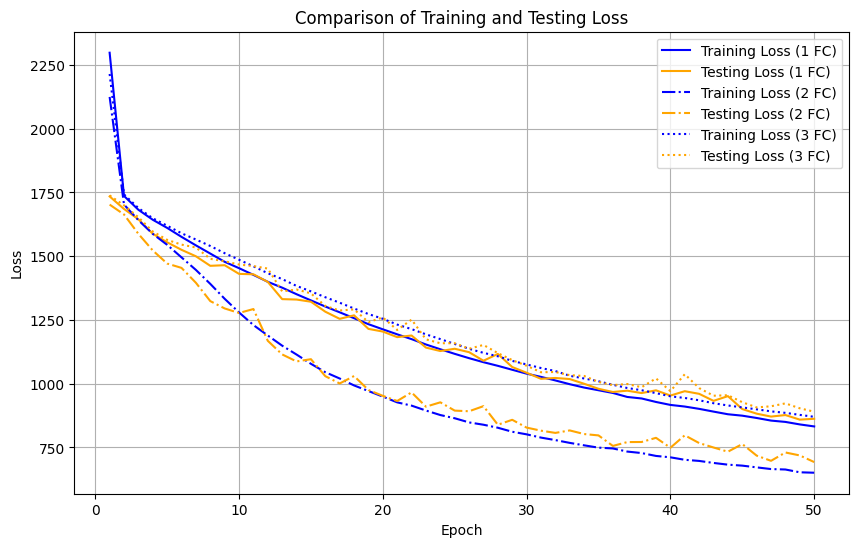

In [21]:
# Create a single plot
plt.figure(figsize=(10, 6))

# Plot Training and Testing Loss for 1 FC layer, 128 nodes
plt.plot(range(1, len(train_losses1) + 1), train_losses1, label='Training Loss (1 FC)', color='blue', linestyle='-')
plt.plot(range(1, len(test_losses1) + 1), test_losses1, label='Testing Loss (1 FC)', color='orange', linestyle='-')

# Plot Training and Testing Loss for 2 FC layers, 128 nodes
plt.plot(range(1, len(train_losses2) + 1), train_losses2, label='Training Loss (2 FC)', color='blue', linestyle='-.')
plt.plot(range(1, len(test_losses2) + 1), test_losses2, label='Testing Loss (2 FC)', color='orange', linestyle='-.')

# Plot Training and Testing Loss for 3 FC layers, 128 nodes
plt.plot(range(1, len(train_losses3) + 1), train_losses3, label='Training Loss (3 FC)', color='blue', linestyle=':')
plt.plot(range(1, len(test_losses3) + 1), test_losses3, label='Testing Loss (3 FC)', color='orange', linestyle=':')

# Customize the plot
plt.title('Comparison of Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [22]:
# Save results to a file
results_file = "fc_layer count.txt"

with open(results_file, 'w') as file:
    for i in range(1,4):
        file.write(f"Layer : {i}:\n")
        file.write(f"Train Loss: {eval(f'train_losses{i}')}\n")
        file.write(f"Test Loss: {eval(f'test_losses{i}')}\n")
        file.write("-" * 50 + "\n\n")
        